## The Darcy's equation

We consider the following Darcy flows in a 2D area filled with porous materials. The governing PDE is 
$$
-\nabla( K(x,y) \nabla P(x,y)) = f(x,y), \quad x\in\Omega
$$  
where $K$ is the permeability field, $P$ is the pressure, and $f$ is a source term which can be either a constant or a space-dependent function.
### (1.1) Neural Operator learning problem

The first example of Darcy flow is defined in a rectangular domain $\Omega=[0,1]^2$ with zero Dirichlet boundary condition. We are interested in learning the mapping from the permeability field $K(x,y)$ to the pressure field $P(x,y)$, i.e.,
$$
\mathcal{G}: K(x,y) \rightarrow P(x,y)
$$

## (2) The Physics-informed Neural Operator method

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 1234
setup_seed(random_seed)
device = 'cudaa:0'
dtype = torch.float32
problem_name = 'DarcyFlow_pwc'
tag = 'fdm'
######################################
# Load training data
######################################
data_train = h5py.File('../../Problems/DarcyFlow_2d/pwc_train.mat', 'r')
data_test = h5py.File('../../Problems/DarcyFlow_2d/pwc_test_in.mat', 'r')
print(data_train.keys())
print(data_test.keys())
res = 29
######################################
from Utils.utils import *
n_train, n_test = 1000, 200
#
def get_data(data, ndata, dtype, res_coe=res, res_test=res, n0=0):
    a = np2tensor(np.array(data["coeff"][...,n0:n0+ndata]).T, dtype)
    a[a==1.] = 10.; a[a==0.] = 5.;
    u = np2tensor(np.array(data["sol_fem"][...,n0:n0+ndata]).T, dtype)
    #
    X_coe, Y_coe = np.array(data['X']).T, np.array(data['Y']).T
    mesh = np2tensor(np.vstack([X_coe.ravel(), Y_coe.ravel()]).T, dtype)
    gridx = mesh.reshape(1, res_coe, res_coe, 2)
    #
    ax = torch.cat([a.reshape(ndata, res_coe, res_coe,1), gridx.repeat(ndata, 1, 1, 1)], dim=-1)
    try:
        u = u.reshape(ndata, res_coe, res_coe, 1)
    except:
        X_sol, Y_sol = np.array(data['X_sol']).T, np.array(data['Y_sol']).T
        mesh = np2tensor(np.vstack([X_sol.ravel(), Y_sol.ravel()]).T, dtype)
        gridx = mesh.reshape(1, res_test, res_test, 2)
        #
        u = u.reshape(ndata, res_test, res_test, 1)
    
    return ax, u, gridx.reshape(-1,2)
#
ax_train, u_train, grid_train = get_data(data_train, n_train, dtype)
ax_test, u_test, grid_test = get_data(data_test, n_test, dtype)
#
print('The shape of ax_train:', ax_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of grid_train:', grid_train.shape)
print('The shape of ax_test:', ax_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of grid_test:', grid_test.shape)
######################################
# Generate mesh grids for calculating gradients
######################################
from Utils.GenPoints import Point2D
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)
#
N_mesh = 29
x_mesh = pointGen.inner_point(N_mesh, method='mesh')
print('x_mesh shape:', x_mesh.shape)

<KeysViewHDF5 ['X', 'Y', 'coeff', 'sol_fdm', 'sol_fem']>
<KeysViewHDF5 ['X', 'Y', 'coeff', 'sol_fdm', 'sol_fem']>
The shape of ax_train: torch.Size([1000, 29, 29, 3])
The shape of u_train: torch.Size([1000, 29, 29, 1])
The shape of grid_train: torch.Size([841, 2])
The shape of ax_test: torch.Size([200, 29, 29, 3])
The shape of u_test: torch.Size([200, 29, 29, 1])
The shape of grid_test: torch.Size([841, 2])
x_mesh shape: torch.Size([841, 2])


### (3.2) Define the loss class

In [2]:
###############################
# Define Loss Class
###############################
from Utils.Grad import *
from torch.autograd import grad, Variable

########################################
class fun_a(object):

    def __init__(self, res):
        super(fun_a, self).__init__()
        self.res = res
        self.delta = 1./(res-1)

    def __call__(self, x, a):
        a = a.squeeze(-1)
        x_loc = torch.floor(x[...,0] / self.delta + 0.5).int()
        y_loc = torch.floor(x[...,1] / self.delta + 0.5).int()
        loc = y_loc * self.res + x_loc
        #
        img = a[torch.arange(a.size(0)).unsqueeze(1), loc]
        
        return img.unsqueeze(-1)

# #####################################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, ax):
        x_mesh, y_mesh = ax[..., 1:2], ax[..., 2:3]
        u = u * torch.sin(np.pi * x_mesh)*torch.sin(np.pi * y_mesh)
        return u
        
##############################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.mollifer = mollifer()
        self.fun_a = fun_a(res=res)
        self.model_u = solver.model_dict['u']
        #
        self.x_mesh = x_mesh.to(self.device)
        self.deltax = 1/(N_mesh-1)
        self.deltay = 1/(N_mesh-1)

    def Loss_pde(self, ax, w_pde, u_true=None):
        if w_pde>0.:
            n_batch = ax.shape[0]
            ########################
            x = Variable(self.x_mesh.repeat(n_batch, 1, 1), requires_grad=True)
            try: 
                a = self.fun_a(self.x_mesh)
            except:
                a = self.fun_a(x, ax[...,0:1].reshape(n_batch, -1, 1)) 
            x = x.reshape(-1, N_mesh, N_mesh, 2)
            a = a.reshape(-1, N_mesh, N_mesh, 1)
            ax = torch.cat([a,x], dim=-1)
            #
            u = self.model_u(ax)
            u = self.mollifer(u, ax)
            # 
            if (self.deltax is not None) and (self.deltay is not None):
                dudx, dudy = FDM_2d(u, self.deltax, self.deltay) 
                adux = ax[:,1:-1,1:-1,0:1] * dudx 
                aduy = ax[:,1:-1,1:-1,0:1] * dudy 
                dauxdx, _ = FDM_2d(adux, self.deltax, self.deltay) 
                _, dauydy = FDM_2d(aduy, self.deltax, self.deltay) 
            else:
                x_mesh, y_mesh = ax[...,1:2], ax[...,2:3]
                dudx, dudy = FDM_2d(u, x_mesh, y_mesh) 
                adux = ax[:,1:-1,1:-1,0:1] * dudx 
                aduy = ax[:,1:-1,1:-1,0:1] * dudy
                dauxdx, _ = FDM_2d(adux, x_mesh[:,1:-1,1:-1,:], y_mesh[:,1:-1,1:-1,:])
                _, dauydy = FDM_2d(aduy, x_mesh[:,1:-1,1:-1,:], y_mesh[:,1:-1,1:-1,:]) 
            #
            left = (- (dauxdx + dauydy)).reshape(n_batch, -1)
            right = 10. * torch.ones_like(left)
            
            return self.solver.getLoss(left, right)
        else:
            return torch.tensor(0.)

    def Loss_data(self, ax, u, w_data):
        if w_data>0:
            try: 
                u_pred = self.model_u(ax)
                u_pred = self.mollifer(u_pred, ax)
                return self.solver.getLoss(u_pred, u)
            except:
                return torch.tensor(0.)
        else:
            return torch.tensor(0.)

    def Error(self, ax, u):
        try:
            u_pred = self.model_u(ax)
            u_pred = self.mollifer(u_pred, ax)
            return self.solver.getError(u_pred, u)
        except:
            return torch.tensor(0.)

######################################
# Steups of the model
######################################
from Solvers.PINO import PINO
solver = PINO.Solver(device, dtype)
netType = 'FNO2d'

###################################### The u model
layer_list = [80]*6
model_u = solver.getModel(in_size=3, out_size=1, modes=[15, 15], 
                          hidden_list=layer_list, netType='FNO2d')

##################
total_trainable_params = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

17,329,697 training parameters.


### (2.3) training and make prediction

#### (2.3.1) train the model

In [3]:
model_dict = {'u':model_u}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR',
                   gamma=0.6, step_size=200)
solver.train(LossClass, ax_train, u_train, ax_test, u_test, 
             w_data=0., w_pde=1., batch_size=50, epochs=1000, epoch_show=50, 
             **{'save_path':f'saved_models/PINO_{tag}/'})

  5%|████                                                                            | 50/1000 [00:22<04:56,  3.21it/s]

Epoch:50 Time:22.2429, loss:15.8718, loss_pde:15.8718, loss_pde:0.0000
                l2_test:0.0460, lr:0.001


 10%|███████▉                                                                       | 100/1000 [00:39<04:51,  3.09it/s]

Epoch:100 Time:39.4611, loss:19.1807, loss_pde:19.1807, loss_pde:0.0000
                l2_test:0.0595, lr:0.001


 15%|███████████▊                                                                   | 150/1000 [00:55<04:35,  3.08it/s]

Epoch:150 Time:55.6743, loss:16.8966, loss_pde:16.8966, loss_pde:0.0000
                l2_test:0.0527, lr:0.001


 20%|███████████████▊                                                               | 200/1000 [01:12<04:20,  3.07it/s]

Epoch:200 Time:72.2321, loss:13.1180, loss_pde:13.1180, loss_pde:0.0000
                l2_test:0.0451, lr:0.0006


 25%|███████████████████▊                                                           | 250/1000 [01:28<04:04,  3.06it/s]

Epoch:250 Time:88.5431, loss:7.8105, loss_pde:7.8105, loss_pde:0.0000
                l2_test:0.0361, lr:0.0006


 30%|███████████████████████▋                                                       | 300/1000 [01:45<04:17,  2.72it/s]

Epoch:300 Time:105.1493, loss:9.1172, loss_pde:9.1172, loss_pde:0.0000
                l2_test:0.0345, lr:0.0006


 35%|███████████████████████████▋                                                   | 350/1000 [02:01<03:36,  3.00it/s]

Epoch:350 Time:121.5556, loss:11.0725, loss_pde:11.0725, loss_pde:0.0000
                l2_test:0.0376, lr:0.0006


 40%|███████████████████████████████▌                                               | 400/1000 [02:18<03:31,  2.83it/s]

Epoch:400 Time:138.7470, loss:9.1646, loss_pde:9.1646, loss_pde:0.0000
                l2_test:0.0368, lr:0.00035999999999999997


 45%|███████████████████████████████████▌                                           | 450/1000 [02:36<03:14,  2.83it/s]

Epoch:450 Time:156.4331, loss:6.9921, loss_pde:6.9921, loss_pde:0.0000
                l2_test:0.0459, lr:0.00035999999999999997


 50%|███████████████████████████████████████▌                                       | 500/1000 [02:54<02:57,  2.82it/s]

Epoch:500 Time:174.1478, loss:5.5007, loss_pde:5.5007, loss_pde:0.0000
                l2_test:0.0382, lr:0.00035999999999999997


 55%|███████████████████████████████████████████▍                                   | 550/1000 [03:11<02:39,  2.82it/s]

Epoch:550 Time:191.8879, loss:5.6045, loss_pde:5.6045, loss_pde:0.0000
                l2_test:0.0387, lr:0.00035999999999999997


 60%|███████████████████████████████████████████████▍                               | 600/1000 [03:29<02:22,  2.81it/s]

Epoch:600 Time:209.6492, loss:8.9119, loss_pde:8.9119, loss_pde:0.0000
                l2_test:0.0379, lr:0.00021599999999999996


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [03:46<01:46,  3.28it/s]

Epoch:650 Time:226.3589, loss:5.5842, loss_pde:5.5842, loss_pde:0.0000
                l2_test:0.0405, lr:0.00021599999999999996


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [04:01<01:31,  3.28it/s]

Epoch:700 Time:241.6105, loss:4.8787, loss_pde:4.8787, loss_pde:0.0000
                l2_test:0.0372, lr:0.00021599999999999996


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [04:17<01:22,  3.03it/s]

Epoch:750 Time:257.6398, loss:5.1532, loss_pde:5.1532, loss_pde:0.0000
                l2_test:0.0400, lr:0.00021599999999999996


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [04:33<01:01,  3.27it/s]

Epoch:800 Time:273.3576, loss:2.9273, loss_pde:2.9273, loss_pde:0.0000
                l2_test:0.0424, lr:0.00012959999999999998


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [04:48<00:46,  3.22it/s]

Epoch:850 Time:288.8362, loss:4.1995, loss_pde:4.1995, loss_pde:0.0000
                l2_test:0.0383, lr:0.00012959999999999998


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [05:04<00:31,  3.22it/s]

Epoch:900 Time:304.3758, loss:2.2983, loss_pde:2.2983, loss_pde:0.0000
                l2_test:0.0391, lr:0.00012959999999999998


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [05:22<00:17,  2.82it/s]

Epoch:950 Time:322.0597, loss:3.4978, loss_pde:3.4978, loss_pde:0.0000
                l2_test:0.0383, lr:0.00012959999999999998


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:39<00:00,  2.94it/s]

Epoch:1000 Time:339.8262, loss:2.5056, loss_pde:2.5056, loss_pde:0.0000
                l2_test:0.0421, lr:7.775999999999999e-05


The total training time is 340.0459


### (3.3) load saved model and make prediction

The shape of u_test: torch.Size([200, 29, 29, 1]) u_pred: torch.Size([200, 29, 29, 1])
The test loss (avg): tensor(0.0682)
The test l2 error (avg): tensor(0.0434)


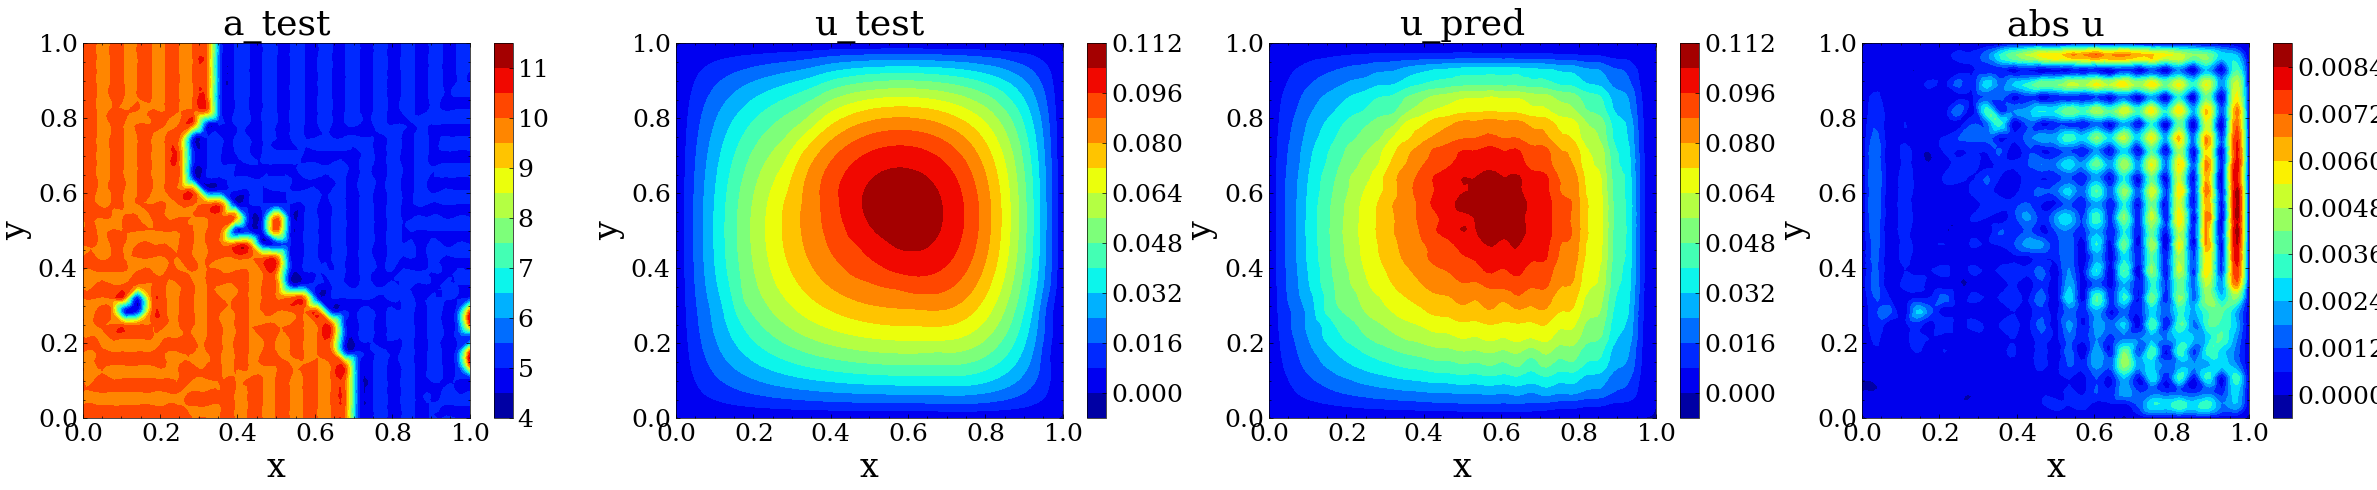

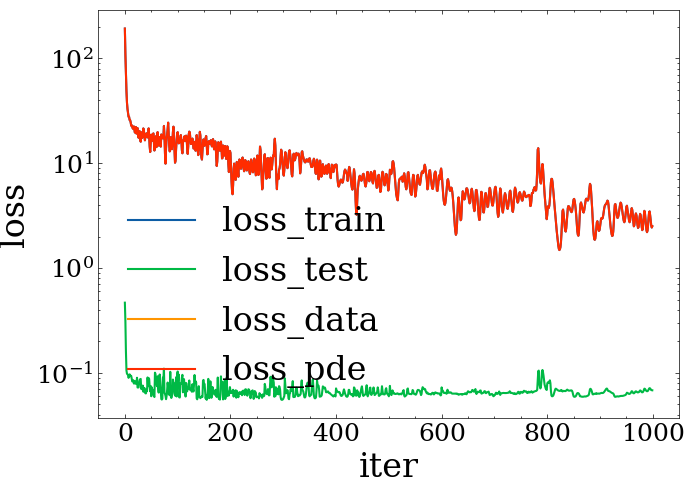

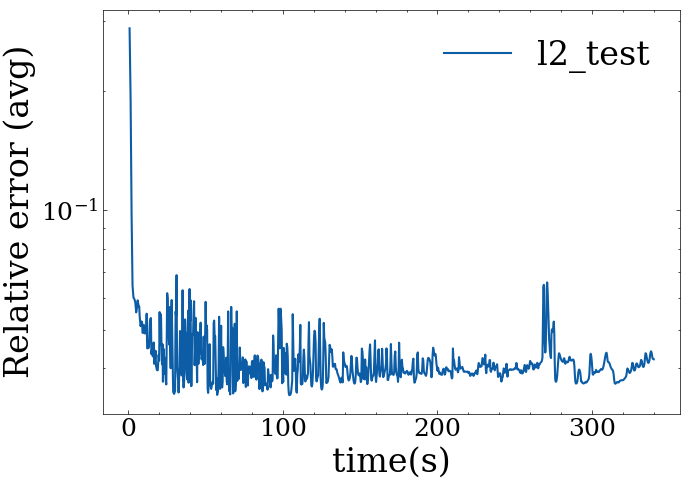

In [3]:
# #######################################
# # Load the trained model
# #######################################
from Solvers.PINO import PINO
solver = PINO.Solver(device, dtype)
tag = 'fdm'
model_trained = solver.loadModel(path=f'saved_models/PINO_{tag}/', name=f'model_pino_final')

#########################################
u_pred = model_trained['u'](ax_test.to(device))
u_pred = mollifer()(u_pred, ax_test.to(device)).detach().cpu()
#
print('The shape of u_test:', u_test.shape, 'u_pred:', u_pred.shape)
print('The test loss (avg):', solver.getLoss(u_pred, u_test))
print('The test l2 error (avg):', solver.getError(u_pred.reshape(1,-1), u_test.reshape(1,-1)))
inx = 0
# # ########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list([grid_train]+[grid_test]*3, [ax_test[inx,...,0:1], u_test[inx], u_pred[inx], torch.abs(u_test[inx]-u_pred[inx])], 
                  ['a_test', 'u_test', 'u_pred', 'abs u'], lb =0.)
############################################# show loss and error
from Utils.PlotFigure import Plot
#
loss_saved = solver.loadLoss(path=f'saved_models/PINO_{tag}/', name='loss_pino')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test'], loss_saved['loss_data'], loss_saved['loss_pde']], 
               ['loss_train', 'loss_test', 'loss_data', 'loss_pde'])
# show error
Plot.show_error([loss_saved['time']]*1, [loss_saved['error']], ['l2_test'])